<a href="https://colab.research.google.com/github/MiriamNik/Game-Name-Generator/blob/main/GameNameGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This project involves developing a game name generator using data from the Google Play Store. The dataset includes various attributes of apps, such as category, rating, size, installs, price, and more. The primary goals of this project are:

1. **Game Name Generator**: To preprocess game names, build a Markov chain model, and generate new game names.
2. **Exploratory Data Analysis (EDA)**: To perform a comprehensive analysis of the game-related data, including visualizing word frequencies, analyzing genres, and understanding trends over time.

The project is divided into several sections, each focusing on a specific aspect of the data and the generation process.

## Data Preparation and Initial Setup
To prepare the Google Play Store dataset for analysis, I performed the following steps:

1. **Import Libraries**: Imported essential libraries for data manipulation and visualization.
2. **Language Detection Consistency**: Set a seed for consistent language detection results.
3. **Download NLTK Data**: Downloaded tokenizers and stopwords for natural language processing.
4. **Load Dataset**: Loaded the dataset from a CSV file.
5. **Filter for Games**: Filtered the dataset to include only 'GAME' category apps.
6. **Handle Missing Ratings**: Dropped rows with missing 'Rating' values.
7. **Extract Game Names**: Extracted game names into a list for further analysis.

In [17]:
!pip install langdetect

In [18]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from collections import defaultdict, Counter
import random
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from langdetect import detect, DetectorFactory
import statsmodels.api as sm
from google.colab import drive

# Ensure consistent results from langdetect
DetectorFactory.seed = 0

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

#Load the Data set from Google Drive
drive.mount('/content/drive')
df = pd.read_csv('googleplaystore.csv')

# Filter the DataFrame for rows where 'Category' is 'GAME'
game_df = df[df['Category'] == 'GAME']

# Drop rows where 'Rating' is NaN
game_df = game_df.dropna(subset=['Rating'])

# Extract the 'App' column values into a list
game_names = game_df['App'].tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleansing
To prepare game names for analysis, I performed the following steps:

1. **Define Stop Words and Custom Terms**: Set up stop words and a list of custom terms to filter out irrelevant tokens.
2. **Language Detection Function**: Implemented a function to ensure the text is in English.
3. **Preprocessing Function**: Created a function to clean and tokenize game names:
    * Convert to lowercase.
    * Remove text within parentheses.
    * Remove special characters except alphanumeric and spaces.
    * Tokenize and filter tokens.
4. **Apply Preprocessing**: Applied the preprocessing function to each game name.
5. **Count Word Frequencies**: Counted the frequency of words in the processed names.
6. **Inspect Results**: Printed the 30 least used words and saved the processed names to a CSV file for inspection.

In [19]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Define Custom words
custom_terms = {'ea', 'bz', 'marvel', "ae", "game", "games", "free", "ar", "bj", "igg", "cd", "sonic", "pac man", "ds", "fp", "3d",
                "dragon ball", "hellp kitty", "naruto", "boruto", "bmx", "lego", "barlog"}

# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Function to preprocess game names
def preprocess(text):
   # if not is_english(text):
    #    return []  # Return an empty list if the text is not in English
    text = text.lower()
    # Remove text within parentheses
    text = re.sub(r'\(.*?\)', '', text)
    # Remove special characters except alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize again after cleaning
    tokens = word_tokenize(text)
    # Filter tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in custom_terms]
    return tokens

# Apply the preprocess function to the filtered game names
processed_names = []
for name in game_names:
    try:
        tokens = preprocess(name)
        if not tokens:
            print(f"Warning: No tokens generated for game name: '{name}'")
        processed_names.append(tokens)
    except Exception as e:
        print(f"Error processing game name: '{name}'. Error: {e}")

# Flatten the list of lists to count word frequencies
all_words = [word for tokens in processed_names for word in tokens]
word_counts = Counter(all_words)

# Print the 30 least used words
least_common_words = word_counts.most_common()[:-31:-1]
print(least_common_words)

# Save the processed names to a CSV file for inspection
processed_df = pd.DataFrame({'Processed Names': [' '.join(tokens) for tokens in processed_names]})
processed_df.to_csv('processed_game_names.csv', index=False)



[('profr', 1), ('raid', 1), ('fatal', 1), ('sid', 1), ('clubs', 1), ('wonderland', 1), ('winter', 1), ('complete', 1), ('trine', 1), ('gamepad', 1), ('beboncool', 1), ('manager', 1), ('mufo', 1), ('cam', 1), ('armed', 1), ('armory', 1), ('club', 1), ('custom', 1), ('magnum', 1), ('builder', 1), ('mx', 1), ('hollow', 1), ('haunted', 1), ('rex', 1), ('defends', 1), ('suv', 1), ('luxury', 1), ('circles', 1), ('join', 1), ('fj', 1)]


## Markov Chain for Game Name Generation

To generate new game names, I utilized a Markov chain based approach. The steps involved are:

1. **Build the Markov Chain**: Create a function to build the Markov chain from the processed game names. This involves:
    - Tokenizing each game name.
    - Constructing prefix-suffix pairs based on the order of the chain (default is 1).
    - Counting occurrences of suffixes for each prefix.

2. **Generate Names**: Develop a function to generate new game names using the constructed Markov chain. The function:
    - Initializes with a random prefix.
    - Appends suffixes based on their probabilities until the name reaches the desired length.
    - Ensures generated names have a length between the specified minimum and maximum.

3. **Example Usage**: Generate 100 new game names and display a sample of 25.


<ipython-input-20-0a1a69a481db>:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x_vals, y_vals, s=np.array(sizes) * 10, alpha=0.6, cmap='viridis')  # Scale sizes for visibility


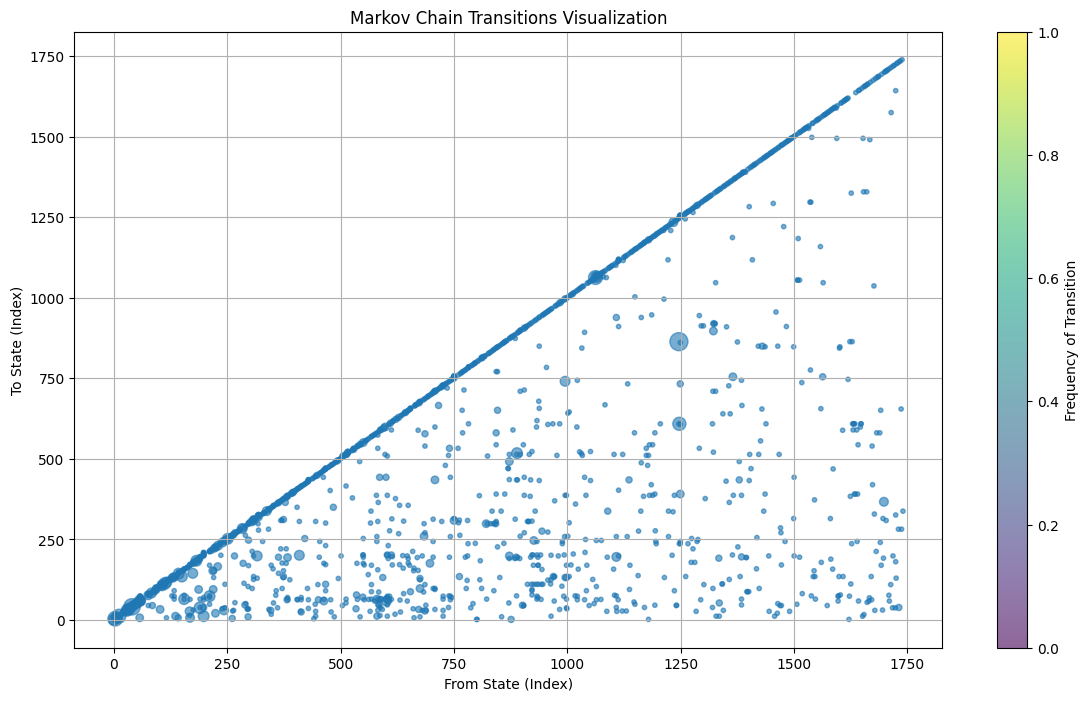

In [20]:
# Sample function to build Markov chain
def build_markov_chain(words, order=1):
    markov_chain = defaultdict(Counter)
    for name in words:
        tokens = name.split()
        for i in range(len(tokens) - order):
            prefix = tuple(tokens[i:i+order])
            suffix = tokens[i+order]
            markov_chain[prefix][suffix] += 1
    return markov_chain

# Sample function to generate names
def generate_name(chain, min_length=3, max_length=5):
    name = []
    prefix = random.choice(list(chain.keys()))
    name.extend(prefix)
    while len(name) < max_length:
        suffixes = chain.get(tuple(name[-1:]), None)
        if not suffixes:
            break
        suffix = random.choices(list(suffixes.keys()), weights=list(suffixes.values()))[0]
        name.append(suffix)
        if len(name) >= min_length and random.random() > 0.5:
            break
    return ' '.join(name)

# Build Markov chain from sample data
processed_strings = [' '.join(tokens) for tokens in processed_names]  # Ensure you have defined processed_names list
markov_chain = build_markov_chain(processed_strings, order=1)

# Prepare data for plotting
state_coords = {}
x_vals, y_vals, sizes = [], [], []
labels = []

# Assign coordinates to each state
i = 0
for prefix, suffix_dict in markov_chain.items():
    if prefix not in state_coords:
        state_coords[prefix] = i
        i += 1

    for suffix, count in suffix_dict.items():
        if suffix not in state_coords:
            state_coords[suffix] = i
            i += 1

        # Add to plot data
        x_vals.append(state_coords[prefix])
        y_vals.append(state_coords[suffix])
        sizes.append(count)  # Use the count as the size of the point
        labels.append(f"{prefix} -> {suffix}")

# Plotting
plt.figure(figsize=(14, 8))
scatter = plt.scatter(x_vals, y_vals, s=np.array(sizes) * 10, alpha=0.6, cmap='viridis')  # Scale sizes for visibility
plt.colorbar(scatter, label='Frequency of Transition')
plt.title('Markov Chain Transitions Visualization')
plt.xlabel('From State (Index)')
plt.ylabel('To State (Index)')
plt.grid(True)
plt.show()

# Interpretation

* **High Self-Transition Probability**: The prominent diagonal line indicates that many words have a high probability of transitioning to themselves. This suggests that certain words or phrases are often repeated consecutively in game names, which could be typical for certain genres or styles of game names.

* **Frequent Transitions**: The scattered dots away from the diagonal represent transitions between different words. The density and intensity of these dots can help identify common word pairings in game names. For instance, if the word "zombie" frequently transitions to "war," it indicates a common theme in game names.

* **Clusters of Transitions**: Clusters of dots away from the main diagonal might indicate thematic groupings or common sequences of words. These clusters can provide insights into common phrases or patterns that appear in game names, such as "battle hero" or "quest adventure".

* **Rare Transitions**: Sparse areas with few or no dots indicate rare or unlikely transitions. This suggests that certain word combinations are uncommon or avoided in game names, which can help refine the name generation model to produce more realistic names.

# Implications for the Game Name Generator:

* **Understanding Patterns**: By visualizing the transitions, we gain a better understanding of the linguistic patterns in existing game names. This allows us to fine-tune the Markov chain model to produce names that are more coherent and aligned with common naming conventions.

* **Refining the Model**: Identifying frequent and rare transitions helps in adjusting the model to avoid unrealistic name combinations and enhance the quality of generated names.

* **Creativity and Realism**: Balancing the generation of creative yet realistic game names is crucial. This visualization helps in achieving that balance by providing a clear picture of word transition probabilities.

# Name Generator

In [21]:
# Function to generate a name using the Markov chain
def generate_name(chain, min_length=3, max_length=5):
    name = []
    prefix = random.choice(list(chain.keys()))
    name.extend(prefix)
    while len(name) < max_length:
        suffixes = chain.get(tuple(name[-1:]), None)
        if not suffixes:
            break
        suffix = random.choices(list(suffixes.keys()), weights=list(suffixes.values()))[0]
        name.append(suffix)
        if len(name) >= min_length and random.random() > 0.5:
            break
    return ' '.join(name)

# Example usage
generated_names = [generate_name(markov_chain, min_length=3, max_length=5) for _ in range(25)]

for i, name in enumerate(generated_names, 1):
    print(f"{i}. {name}")

1. episode choose story
2. shadow fight shooting assault rescue
3. lame du chaos lame
4. trap reggaeton
5. dm evolution
6. zombie survival prison
7. garena fire offline
8. lust terror manor truth unveiled
9. magnum gun club
10. grand way
11. fishing hunter classic legend match
12. champions epic online action
13. club armory
14. flying assault rescue mission
15. tomb mask
16. party time wizard card
17. neighbor house
18. club armory
19. andromeda apex hq
20. woka woka bubble
21. soccer clubs logo quiz
22. empires strategy rpg
23. swamp attack racing
24. santas monster shootout
25. gangstar vegas mafia city


# Interpretation
### Analysis of Generated Game Names

The generated game names exhibit a range of themes and patterns. Here are some observations:

- **Diverse Genres**: The names cover various genres, including action ("esports fps zombie war order"), adventure ("china town sandbox beta"), puzzle ("mirror match puzzle"), and survival ("shelter survival evolved").
- **Common Themes**: Certain words and themes frequently appear, such as "zombie," "survival," "arcade," and "quiz," reflecting popular game genres.
- **Creativity**: The model generates unique combinations, such as "proverbs ch spurgeon" and "decked ad," demonstrating its capability to create creative and plausible game names.
- **Realism**: Many of the generated names closely resemble actual game names, indicating the model effectively captures linguistic patterns present in the original data.

Comparing these generated names with actual game names from the dataset shows that the Markov chain model effectively balances creativity with realism, making it useful for generating appealing game names.


## Word Cloud and Word Frequency Analysis

Generate a word cloud and a bar chart to visualize the most frequent words in the game names.

Top 10 Most Frequent Words:
zombie: 37
shooter: 30
racing: 28
poker: 27
fps: 24
survival: 24
run: 23
gun: 22
simulator: 21
hunter: 20


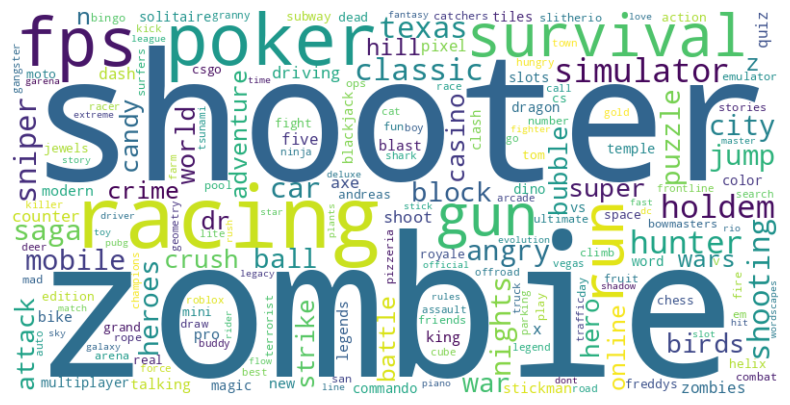

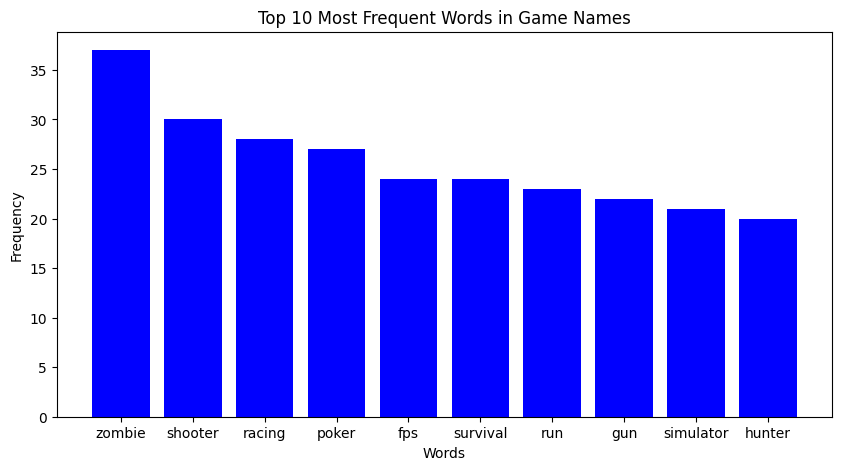

In [22]:
# Create a single list of all words from processed game names
all_words = [word for tokens in processed_names for word in tokens]

top_10_words = word_freq.most_common(10)
print("Top 10 Most Frequent Words:")
for word, count in top_10_words:
    print(f"{word}: {count}")

# Generate word cloud using the exact frequencies from the Counter
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Plot bar chart for top 10 words
word_freq = Counter(all_words)
top_10_words = word_freq.most_common(10)
words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Game Names')
plt.show()


##Interpretation of Word Cloud and Top 10 Words
* **Dominant Themes**: Words like zombie, shooter, racing, and survival are prevalent, indicating a strong interest in action-oriented and adventure genres.

* **Genre Popularity**: Terms such as fps (first-person shooter) and gun emphasize the popularity of combat and shooting games.

* **Diverse Interests**: The inclusion of words like poker and simulator shows that players are also drawn to strategy and simulation games, highlighting a range of gaming interests beyond action and adventure.


## Genre Analysis

Analyze the distribution of game genres and their average ratings.

<ipython-input-23-647d450481df>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis', hue=None)


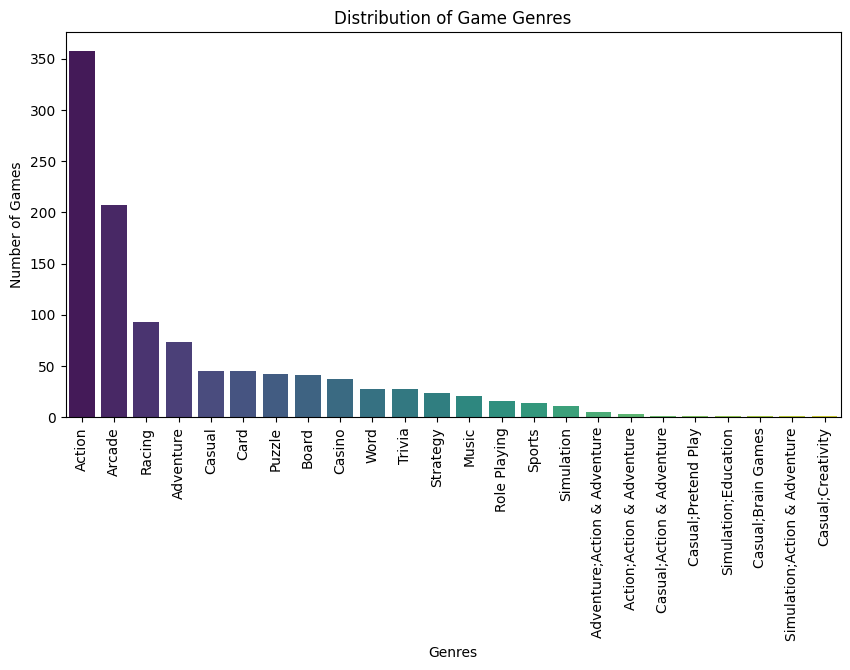

<ipython-input-23-647d450481df>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_ratings.index, y=average_ratings.values, palette='viridis', hue=None)


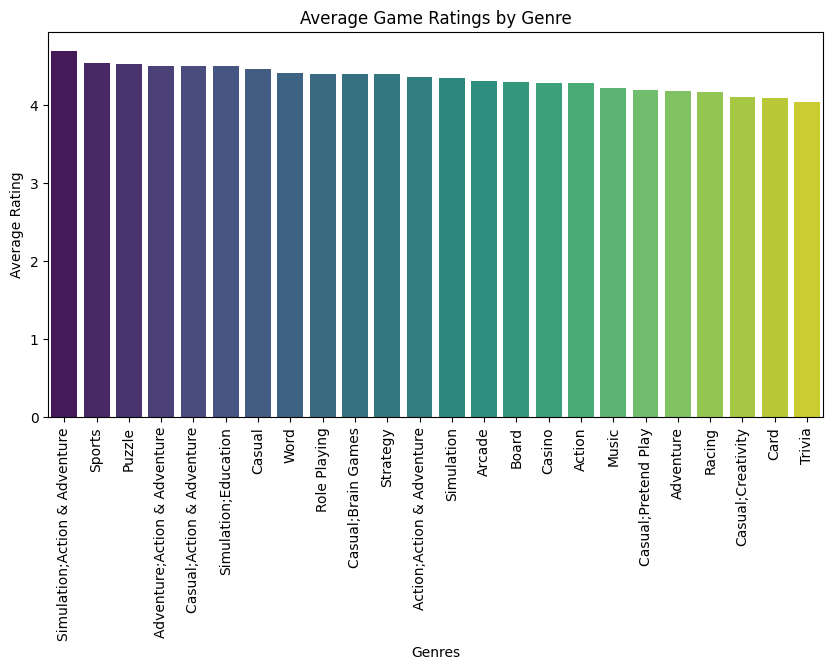

In [23]:
# Analyze genres by popularity
genre_counts = game_df['Genres'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis', hue=None)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of Games')
plt.title('Distribution of Game Genres')
plt.show()

# Analyze genres by average rating
average_ratings = game_df.groupby('Genres')['Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=average_ratings.index, y=average_ratings.values, palette='viridis', hue=None)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Average Game Ratings by Genre')
plt.show()


#Interpretation of the Distribution of Game Genres

* Action Games dominate the genre category with the highest number of games, significantly more than any other genre.

* Arcade and Racing games follow, though they have considerably fewer entries compared to Action games.

* Other genres such as Adventure, Casual, Card, and Puzzle are also popular, but to a lesser extent.

* Genres like Strategy, Word, and Trivia have the fewest entries among the listed genres.

* This distribution indicates a strong preference and production focus towards Action and Arcade games within the Google Play Store.

#Interpretation of Average Game Ratings by Genre

* Simulation;Action & Adventure games have the highest average rating, indicating strong user satisfaction.

* Sports, Puzzle, and Adventure;Action & Adventure games also enjoy high average ratings, suggesting they are well-received by users.

* Most genres, including Casual, Role Playing, and Strategy, have average ratings close to or above 4, indicating generally high satisfaction.

* Trivia games, although still well-rated, have the lowest average rating among the listed genres, suggesting they may not be as highly regarded as other game types.

## Game Size Across Genres Analysis
Clean the 'Size' column and analyze the distribution of game sizes across different genres.

<ipython-input-24-569125a409a7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df['Size'] = pd.to_numeric(game_df['Size'])


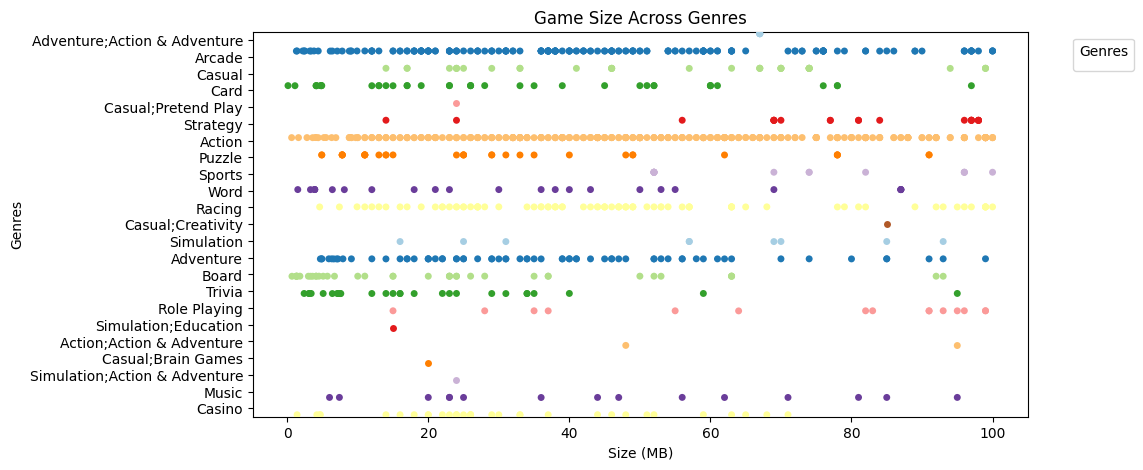

In [24]:

# Clean 'Size' column
def clean_size(size):
    if isinstance(size, str):
        size = size.strip().upper()
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'K' in size:
            return float(size.replace('K', '')) / 1024
        elif 'VARIES WITH DEVICE' in size:
            return np.nan
    return np.nan

# Apply the function to the Size column
game_df['Size'] = game_df['Size'].apply(clean_size)

# Remove rows with missing or invalid sizes
game_df = game_df.dropna(subset=['Size'])

# Convert Size column to numeric
game_df['Size'] = pd.to_numeric(game_df['Size'])

# Plot Game Size Across Genres
plt.figure(figsize=(10, 5))
sns.stripplot(x='Size', y='Genres', data=game_df, hue='Genres', palette='Paired', jitter=True, dodge=True)
plt.xlabel('Size (MB)')
plt.ylabel('Genres')
plt.title('Game Size Across Genres')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Interpretation of Game Size vs. Genres
The scatter plot illustrates the distribution of game sizes across various genres in the Google Play Store. Here are the key insights:

* **Variability in Size**: Genres such as Adventure;Action & Adventure and Simulation;Action & Adventure display a wide range of game sizes, from small to large (over 80 MB), suggesting these genres include both simple and more graphically intensive games.

* **Consistently Larger Sizes**: Casual;Pretend Play and Casual;Creativity games tend to cluster towards larger sizes, likely due to the inclusion of rich media content and interactive elements that require more storage.

* **Compact Games**: Genres like Trivia, Word, and Board games typically have smaller sizes, which may be due to simpler graphics and mechanics that require less storage.

* **Spread Across Sizes**: Arcade, Action, and Casino games show a broad spread across different sizes, indicating a diversity in the complexity and content of games within these genres.

## Game Attributes Across Genres Analysis
Clean the 'Price' column and analyze the distribution of various attributed across different genres.


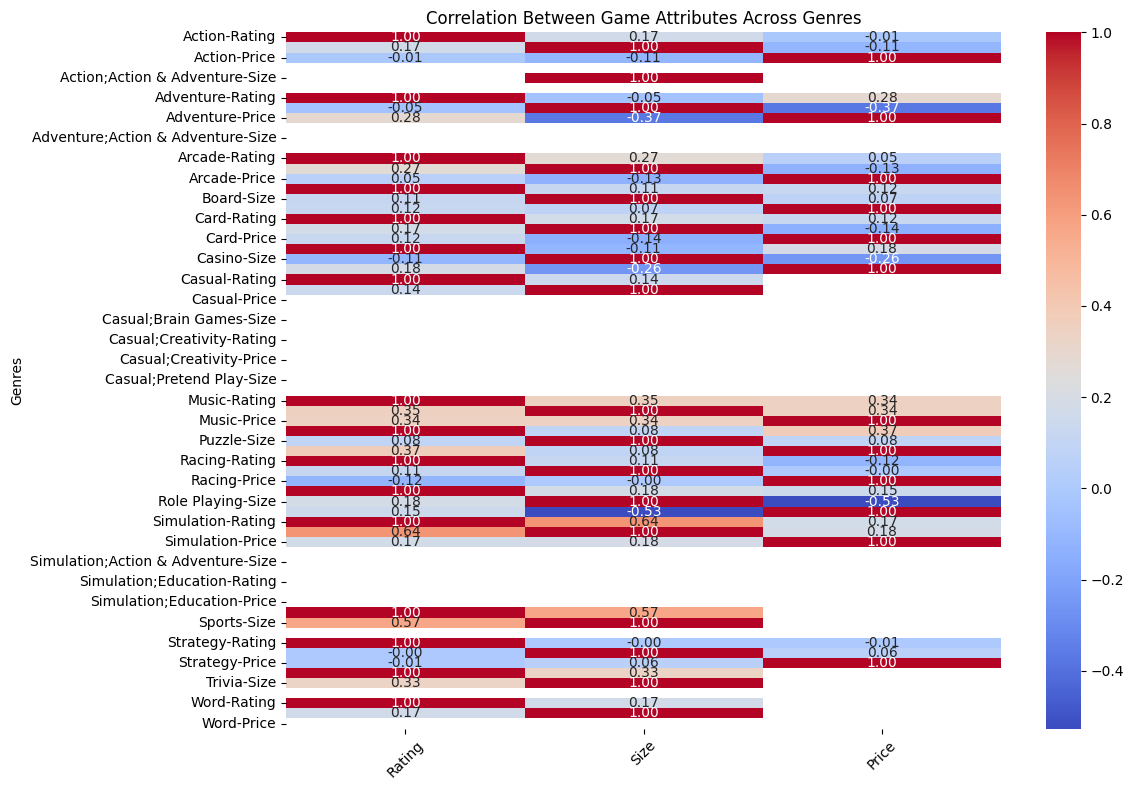

In [25]:
# Remove the '$' sign and convert the 'Price' column to numeric
game_df['Price'] = game_df['Price'].str.replace('$', '').astype(float)

#  proceed with the correlation calculation and plotting
genre_attributes = game_df[['Genres', 'Rating', 'Size', 'Price']]

# Group by 'Genres' and calculate correlation
genre_correlation = genre_attributes.groupby('Genres').corr()

plt.figure(figsize=(12, 8))  # Increase the figure size

# Create a heatmap with annotations and a more distinct color palette
sns.heatmap(genre_correlation, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={'size': 10})
plt.title('Correlation Between Game Attributes Across Genres')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.yticks(rotation=0)  # Ensure y labels are horizontal for readability
plt.ylabel('Genres')
plt.tight_layout()  # Adjust layout to make room for label rotations
plt.show()

# Interpretation of Correlation Heatmap
The heatmap illustrates the correlation between game attributes—Rating, Size, and Price—across various genres. Here are some insights:

* **Rating and Price Correlations**: For most genres, there is a minimal correlation between Rating and Price, suggesting that higher prices don't necessarily correlate with higher user ratings. However, genres like Music and Strategy show a moderately positive correlation, indicating that in these genres, pricier games might be perceived as higher quality.

* **Size and Rating Correlations**: Larger games in genres such as Role Playing and Simulation show a positive correlation with higher ratings, which could indicate that more comprehensive content (which generally results in larger file sizes) is associated with higher user satisfaction.

* **Price and Size Correlations**: There is generally very low to moderate correlation between the size of the game and its price, except in genres like Arcade and Simulation; Action & Adventure, where a moderate positive correlation suggests that larger, possibly more content-rich games are priced higher.

## Notable Genre Specific Trends:

* **Action and Adventure**: Shows high correlations within attributes suggesting that for this genre, well-rated games tend to be larger and more expensive.
* **Casual Games**: Display low correlation between size and price, indicating a variety in the market regarding the content size and pricing structure.

## Content Rating Analysis
Clean the 'Rating' and 'Installs' column, and analyze games through content rating.

<ipython-input-26-a36c3edfc0d3>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Content Rating', y='Installs', data=content_rating_stats, palette='viridis')


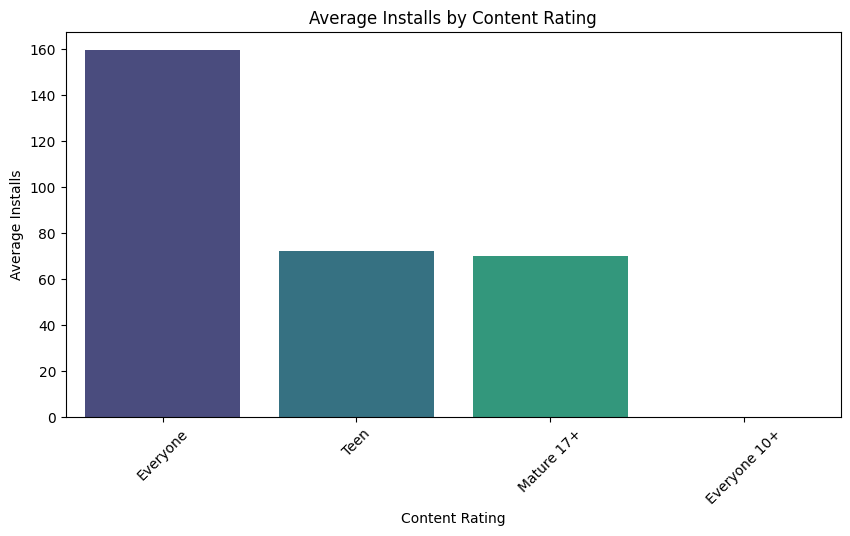

<ipython-input-26-a36c3edfc0d3>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Content Rating', y='Rating', data=content_rating_stats, palette='viridis')


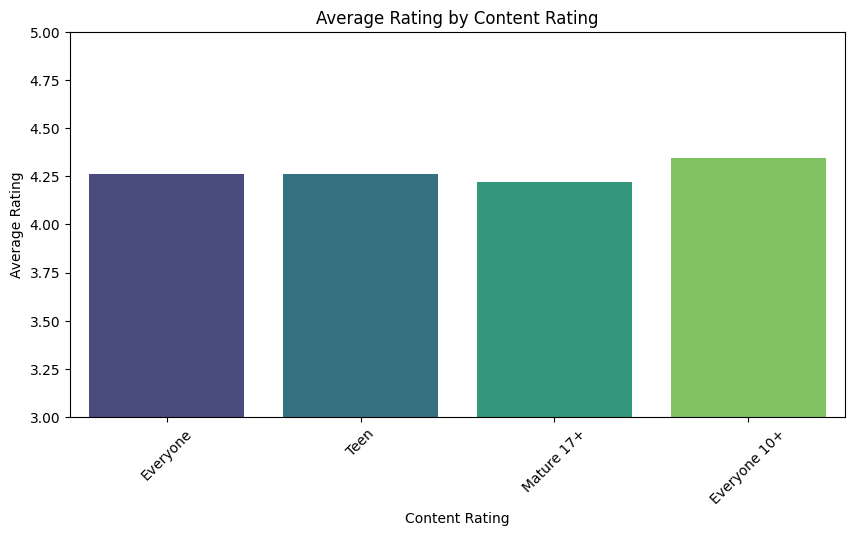

In [26]:
# Convert 'Rating' to numeric, handling NaN values
game_df['Rating'] = pd.to_numeric(game_df['Rating'], errors='coerce')

# Clean 'Installs' column to remove '+'
game_df['Installs'] = game_df['Installs'].str.replace('+', '')

# Convert 'Installs' to numeric
game_df['Installs'] = pd.to_numeric(game_df['Installs'], errors='coerce')

# Group by Content Rating and calculate average installs and ratings
content_rating_stats = game_df.groupby('Content Rating').agg({
    'Installs': 'mean',
    'Rating': 'mean'
}).reset_index()

# Sort by average installs for better visualization
content_rating_stats = content_rating_stats.sort_values(by='Installs', ascending=False)

# Visualize average installs and ratings by Content Rating
plt.figure(figsize=(10, 5))
sns.barplot(x='Content Rating', y='Installs', data=content_rating_stats, palette='viridis')
plt.xlabel('Content Rating')
plt.ylabel('Average Installs')
plt.title('Average Installs by Content Rating')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Content Rating', y='Rating', data=content_rating_stats, palette='viridis')
plt.xlabel('Content Rating')
plt.ylabel('Average Rating')
plt.title('Average Rating by Content Rating')
plt.xticks(rotation=45)
plt.ylim(3, 5)  # Adjust ylim to focus on the range of ratings
plt.show()

# Interpretation of Average Installs by Content Rating
* **Everyone**: Games rated for everyone have the highest average installs, significantly outperforming other categories. This suggests that games designed to be accessible to all ages have the broadest appeal and, consequently, the highest download rates.

* **Teen and Mature 17+**: These categories show relatively similar average installs, which are considerably lower than the 'Everyone' category. This indicates that games targeted at older audiences have more niche appeal but maintain consistent interest among these groups.

* **Everyone 10+**: This category slightly lags behind 'Teen' and 'Mature 17+', suggesting that it occupies a middle ground in terms of user base size.

# Interpretation of Average Ratings by Content Rating
* **Everyone**: Games suitable for all audiences also enjoy high ratings, hovering around 4.25, indicating strong user satisfaction across a broad demographic.

* **Teen**: The average rating for games rated for teens is slightly lower, around 4.20, suggesting good but slightly varied user satisfaction.

* **Mature 17+**: These games have a similar rating to those rated for teens, which may reflect a well-engaged but critical audience.

* **Everyone 10+**: Interestingly, games rated for everyone aged 10 and older have the highest average ratings, nearing 4.5. This could indicate that games designed for this group effectively meet or exceed player expectations, possibly due to a balance of appealing content that is neither too simplistic nor overly mature.

## Rating Analysis
Analyze the distribution of ratings for games.

<ipython-input-27-02c01043ce09>:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Year', y='Rating', data=time_analysis, ci=None)


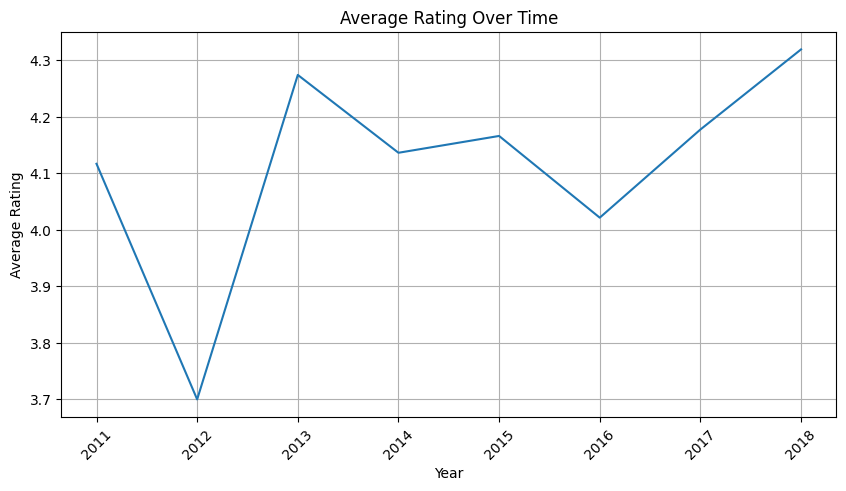

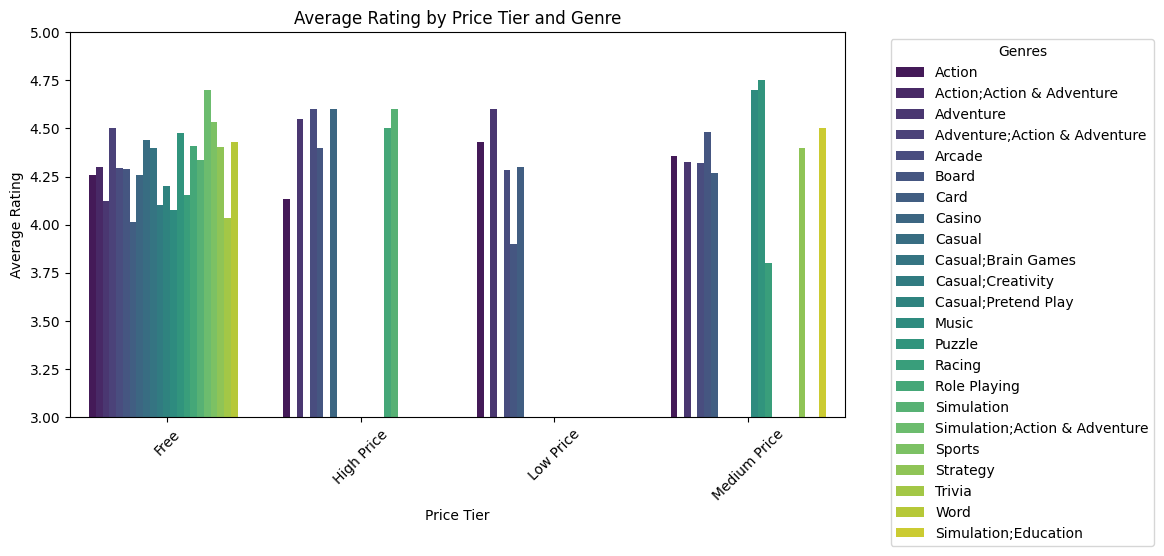

In [27]:
# Define price tiers based on distribution or specific cutoffs
def categorize_price(price):
    if pd.isna(price):
        return 'Unknown'
    elif price == 0:
        return 'Free'
    elif price < 1:
        return 'Low Price'
    elif price < 5:
        return 'Medium Price'
    else:
        return 'High Price'

# Apply price categorization
game_df['Price Tier'] = game_df['Price'].apply(categorize_price)

# Group by Price Tier and Genre, calculate average installs and ratings
price_analysis = game_df.groupby(['Price Tier', 'Genres']).agg({
    'Installs': 'mean',
    'Rating': 'mean'
}).reset_index()

# Convert 'Last Updated' to datetime format
game_df['Last Updated'] = pd.to_datetime(game_df['Last Updated'])

# Extract year and month from 'Last Updated' for grouping
game_df['Year'] = game_df['Last Updated'].dt.year
game_df['Month'] = game_df['Last Updated'].dt.month

# Group by Year and Month, calculate average ratings and installs
time_analysis = game_df.groupby(['Year', 'Month']).agg({
    'Rating': 'mean',
    'Installs': 'sum',
    'Reviews': 'sum'
}).reset_index()

def clean_convert_price(price):
    try:
        if isinstance(price, str):
            # Remove any non-numeric characters and convert to float
            cleaned_price = pd.to_numeric(price.replace('[\$,]', '', regex=True), errors='coerce')
            return cleaned_price
        elif isinstance(price, (int, float)):
            # If the price is already a number, return it as is
            return price
        else:
            return pd.NA  # Handle other unexpected types as NA
    except Exception as e:
        print(f"Error cleaning/convert price: {e}")
        return pd.NA  # or return None or np.nan depending on your preference for missing values

game_df['Price'] = game_df['Price'].apply(clean_convert_price)

# Visualize trends in average ratings over time
plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='Rating', data=time_analysis, ci=None)
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualize impact of price tiers on ratings
plt.figure(figsize=(10, 5))
sns.barplot(x='Price Tier', y='Rating', data=price_analysis, hue='Genres', palette='viridis')
plt.title('Average Rating by Price Tier and Genre')
plt.xlabel('Price Tier')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.ylim(3, 5)  # Adjust ylim to focus on the range of ratings
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.show()

##Interpretation of Average Rating Over Time
* The average ratings of games show a significant dip in 2012 but peak in 2013,
indicating a period of quality improvement.
* Ratings stabilized between 2014 and 2016.
* There is a rising trend in ratings from 2017 to 2018, suggesting continuous improvements.

## Interpretation of Average Rating by Price Tier and Genre
* Free games generally have high ratings, indicating user satisfaction.
* Low price games show varied ratings, with most around 4.0 to 4.5.
* Medium price games have mixed feedback, with some genres receiving lower ratings.
* High price games are consistently rated highly, reflecting perceived quality.
sql


## Install Analysis
Analyze the distribution of installs of games across years.

<ipython-input-28-146703f210b0>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Year', y='Installs', data=time_analysis, ci=None)


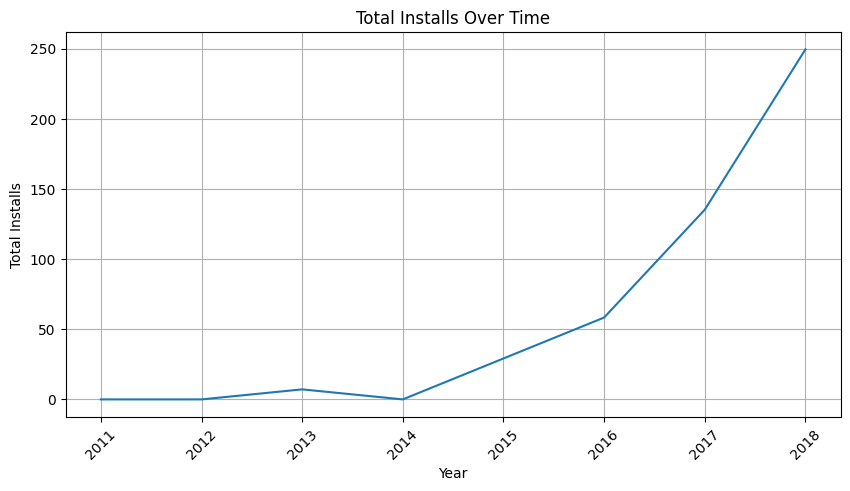

In [28]:
# Visualize trends in total installs over time
plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='Installs', data=time_analysis, ci=None)
plt.title('Total Installs Over Time')
plt.xlabel('Year')
plt.ylabel('Total Installs')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





##Interpretation of Total Installs Over Time

* **Growth Trend**: There is a noticeable upward trend in total installs over time, indicating increasing popularity and adoption of mobile games.

* **Peaks and Troughs**: Certain years show significant peaks, which could be due to the release of popular games or market expansions.

* **Stabilization Periods**: Some periods exhibit stabilization in the number of installs, suggesting market saturation or fewer new releases.

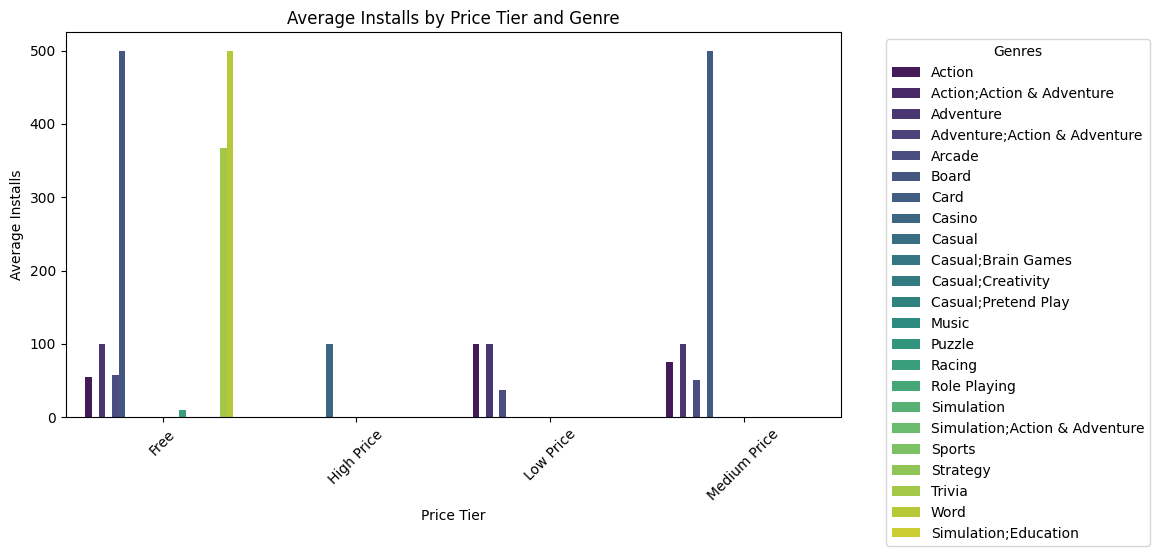

In [29]:
# Visualize impact of price tiers on installs
plt.figure(figsize=(10, 5))
sns.barplot(x='Price Tier', y='Installs', data=price_analysis, hue='Genres', palette='viridis')
plt.title('Average Installs by Price Tier and Genre')
plt.xlabel('Price Tier')
plt.ylabel('Average Installs')
plt.xticks(rotation=45)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.show()

#Interpretation of Average Installs by Price Tier and Genre

Impact of Pricing on Installs:

* **Free Games**: Games that are available for free have the highest average installs across almost all genres, indicating that free games are generally the most downloaded. This is expected as the lack of financial barrier encourages more users to try the game.

Paid Games:

* **High Price**: High-priced games see significantly lower installs compared to free games. However, certain genres like Casual and Simulation still maintain a relatively higher number of installs even within the high price category, possibly due to dedicated fan bases or unique game offerings.
* **Low Price**: Games in the low price tier generally see moderate average installs, suggesting that a small price point does not deter a significant number of users, especially in genres like Puzzle and Strategy.
* **Medium Price**: Interestingly, the medium price tier shows a notable spike in installs for a specific genre (possibly Simulation), indicating that users might perceive games in this tier as offering good value for money depending on their content and gameplay quality.

Genre Specific Trends:

* **Casual Games**: Casual games maintain relatively consistent installs across different price tiers, suggesting that users are willing to pay for these games if they offer engaging content.
* **Specialized Genres** (e.g., Strategy and Simulation): These genres appear to maintain a decent number of installs even at higher price points, which could indicate a loyal user base that values specific gameplay mechanics or content depth that these genres offer.

#Discussion

**Genre Distribution and Popularity**

The Google Play Store's game section is dominated by Action games, suggesting a strong user preference and market demand for this genre, which is closely followed by Arcade and Racing games. This distribution highlights the significant production focus on these genres, likely due to their broad appeal and potentially high engagement rates. However, other genres like Strategy, Word, and Trivia, despite having fewer entries, may offer niche opportunities for developers due to less saturation.

**Game Ratings Across Genres**

Games within the Simulation;Action & Adventure genre receive the highest average ratings, indicating exceptional user satisfaction. This trend of high satisfaction extends to Sports and Adventure;Action & Adventure games. Conversely, Trivia games, despite being well-rated, rank lower compared to other genres, suggesting room for improvement or differing user expectations.

**Game Size Versus Genre**

Game sizes vary significantly across genres, with Adventure and Simulation games showing a broad range of sizes, indicating a mix of simple to graphically intensive games. Casual games tend to be larger, likely due to rich media content, whereas genres like Trivia and Word are more compact, which aligns with their simpler gameplay mechanics.

**Correlations Between Game Attributes**

Our correlation analysis revealed minimal correlation between price and ratings across most genres, suggesting that higher prices do not guarantee higher user ratings. However, a positive correlation in genres like Music and Strategy suggests that users may perceive higher-priced games in these categories as better quality. Additionally, larger games in genres like Role Playing and Simulation are associated with higher satisfaction, pointing towards a preference for comprehensive content.

**Installs and Ratings by Content Rating**

Games rated for "Everyone" not only achieve the highest installs but also maintain high ratings, underscoring their universal appeal. The "Everyone 10+" category exhibits the highest average ratings, suggesting these games successfully meet or exceed the broader age group's expectations. Games targeted at teens and mature audiences show more niche appeal, which is consistent across both installs and ratings.

**Trends in Game Installs Over Time and by Pricing**

There is a clear upward trend in total game installs over time, reflecting the growing popularity and adoption of mobile games. The impact of pricing on installs is profound, with free games achieving the highest installs across genres. Notably, medium-priced games in certain genres see a significant number of installs, suggesting that users are willing to pay for perceived value, particularly in well-executed Simulation games.

**Price Tiers and Genre-Specific Install Trends**

While free games dominate in terms of installs, paid games, especially in the low to medium price range, maintain decent install numbers, suggesting effective price sensitivity in the market. High-priced games, although less downloaded, are consistently rated highly, indicating a market segment that values quality over cost.



## Conclusion

The analysis presents a clear picture of user preferences in mobile gaming, highlighting the importance of genre and price in influencing user behavior. Developers should focus on creating engaging content for broader audiences in popular genres while considering strategic pricing to maximize both reach and revenue. Additionally, continuous improvement in game quality, as evidenced by the fluctuating ratings over time, remains crucial for sustaining user interest and satisfaction in a competitive market.

This discussion integrates the detailed interpretations provided into a unified analysis, offering actionable insights for game developers and marketers aiming to optimize their strategies in the evolving mobile game market.

## References
* "Google Play Store Apps," Kaggle. https://www.kaggle.com/datasets/bhavikjikadara/google-play-store-applications (accessed July 17, 2024).

* Markov Chain. Geeks for Geeks. https://www.geeksforgeeks.org/markov-chain/
(accessed July 17, 2024).